In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN1 = 16
NUM_HIDDEN2 = 4
NUM_STATS = 3*K
NUM_LATENTS =  K
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'gibbs-nc'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/obs.npy')).float()
STATES = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('gmm_dataset/obs_mu.npy')).float()
OBS_SIGMA = torch.from_numpy(np.load('gmm_dataset/obs_sigma.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_eta(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.mus_mu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        self.mus_log_sigma = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 6
        self.prior_alpha = torch.ones((K, D)) * 3
        self.prior_beta = torch.ones((K, D)) * 3
        if CUDA:
            self.prior_mu = self.prior_mu.cuda()
            self.prior_sigma = self.prior_sigma.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, stat1, stat2, stat3):
        q = probtorch.Trace()
        stats_d1 = torch.cat((stat1, stat2[:, :, :, 0], stat3[:, :, :, 0]), -1) ## S * B * 3K
        stats_d2 = torch.cat((stat1, stat2[:, :, :, 1], stat3[:, :, :, 1]), -1) ## S * B * 3K
        ##
        q_mu1 = self.mus_mu(stats_d1)
        q_sigma1 = self.mus_log_sigma(stats_d1).exp()
        q_mu2 = self.mus_mu(stats_d2)
        q_sigma2 = self.mus_log_sigma(stats_d2).exp()        
        q_mu = torch.cat((q_mu1.unsqueeze(-1), q_mu2.unsqueeze(-1)), -1)
        q_sigma = torch.cat((q_sigma1.unsqueeze(-1), q_sigma2.unsqueeze(-1)), -1)
        ##
        q_alpha1 = self.tau_log_alpha(stats_d1).exp()
        q_beta1 = self.tau_log_beta(stats_d1).exp()
        q_alpha2 = self.tau_log_alpha(stats_d2).exp()
        q_beta2 = self.tau_log_beta(stats_d2).exp()
        ##
        q_alpha = torch.cat((q_alpha1.unsqueeze(-1), q_alpha2.unsqueeze(-1)), -1)
        q_beta = torch.cat((q_beta1.unsqueeze(-1), q_beta2.unsqueeze(-1)), -1)
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha,
                q_beta,
                value=precisions,
                name='precisions')
        ##
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')

        p = probtorch.Trace()
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        p.gamma(self.prior_alpha,
                self.prior_beta,
                value=q['precisions'],
                name='precisions')   
        
        return q, p
        
def initialize():
    enc_eta = Enc_eta()
    if CUDA:
        enc_eta.cuda()
    optimizer =  torch.optim.Adam(list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_eta, optimizer

In [5]:
def Eubo_idw(q, p, obs, states, K, D):
    ## for individual importance weight, S * B * K
    log_q_mu = q['means'].log_prob.sum(-1)
    log_q_tau = q['precisions'].log_prob.sum(-1)
    log_p_mu = p['means'].log_prob.sum(-1)
    log_p_tau = p['precisions'].log_prob.sum(-1)

    obs_mu = q['means'].value.view(NUM_SAMPLES, BATCH_SIZE, K, D)
    obs_sigma = 1. / (q['precisions'].value.view(NUM_SAMPLES, BATCH_SIZE, K, D)).sqrt()
    ##
    labels = states.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
    obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
    log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1) ## S * B * N, need to group
    log_obs = torch.cat([((labels==k).float() * log_obs).sum(-1).unsqueeze(-1) for k in range(K)], -1)
    log_weights = log_obs + log_p_mu + log_p_tau - log_q_mu - log_q_tau
    weights = F.softmax(log_weights, 0).detach()
    eubo = (weights * log_weights).sum(0).sum(-1).mean()
    elbo = log_weights.sum(-1).mean()
    ess = (1. / (weights**2).sum(0)).mean(-1).mean()
    return eubo, elbo, ess, weights

In [6]:
enc_eta, optimizer = initialize()

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_mu_ex = []
KLs_mu_in = []
KLs_tau_ex = []
KLs_tau_in = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\tIWKLs_mu_ex\tIWKLs_mu_in\tIWKLs_tau_ex\tIWKLs_tau_in\tAKLs_mu_ex\tAKLs_mu_in\tAKLs_tau_ex\tAKLs_tau_in\n')
flog.close()
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    IWKL_mu_ex = 0.0
    IWKL_mu_in = 0.0
    IWKL_tau_ex = 0.0
    IWKL_tau_in = 0.0
    AKL_mu_ex = 0.0
    AKL_mu_in = 0.0
    AKL_tau_ex = 0.0
    AKL_tau_in = 0.0
    
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()_conjugate
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        states = STATES[batch_indices]
        obs_mu_true = OBS_MU[batch_indices]
        obs_sigma_true = OBS_SIGMA[batch_indices]
        data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
        if CUDA:
            obs =data.cuda()[:, :, :, :2]
            states = data.cuda()[:, :, :, 2:]
            obs_mu_true = obs_mu_true.cuda()
            obs_sigma_true = obs_sigma_true.cuda()
        stat1, stat2, stat3 = data_to_stats(obs, states, N, K, D)
        q, p = enc_eta(stat1, stat2, stat3)
        eubo, elbo, ess, weights = Eubo_idw(q, p, obs, states, K, D)
        ## KLs for mu given true sigma
        post_mu, post_sigma = Post_mu(stat1, stat2, enc_eta.prior_mu, enc_eta.prior_sigma, obs_sigma_true, D)
        q_mu_mu = q['means'].dist.loc
        q_mu_sigma = q['means'].dist.scale
        kl_mu_ex, kl_mu_in = kls_normals(q_mu_mu, q_mu_sigma, post_mu, post_sigma)
        ##KLs for precision given true mu
        post_alpha, post_beta = Post_tau(stat1, stat2, stat3, enc_eta.prior_alpha, enc_eta.prior_beta, obs_mu_true, D)
        q_tau_alpha = q['precisions'].dist.concentration
        q_tau_beta = q['precisions'].dist.rate
        kl_tau_ex, kl_tau_in = kls_gammas(q_tau_alpha, q_tau_beta, post_alpha, post_beta)
        iwkl_mu_ex = (weights * kl_mu_ex).sum(0).sum(-1).mean()
        iwkl_mu_in = (weights * kl_mu_in).sum(0).sum(-1).mean()
        iwkl_tau_ex = (weights * kl_tau_ex).sum(0).sum(-1).mean()
        iwkl_tau_in = (weights * kl_tau_in).sum(0).sum(-1).mean()
        ##
        akl_mu_ex = kl_mu_ex.sum(-1).mean()
        akl_mu_in = kl_mu_in.sum(-1).mean()
        akl_tau_ex = kl_tau_ex.sum(-1).mean()
        akl_tau_in = kl_tau_in.sum(-1).mean()
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        IWKL_mu_ex += iwkl_mu_ex.item()
        IWKL_mu_in += iwkl_mu_in.item()
        IWKL_tau_ex += iwkl_tau_ex.item()
        IWKL_tau_in += iwkl_tau_in.item()
        ##
        AKL_mu_ex += akl_mu_ex.item()
        AKL_mu_in += akl_mu_in.item()
        AKL_tau_ex += akl_tau_ex.item()
        AKL_tau_in += akl_tau_in.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 

    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               IWKL_mu_ex/NUM_BATCHES, IWKL_mu_in/NUM_BATCHES, IWKL_tau_ex/NUM_BATCHES, IWKL_tau_in/NUM_BATCHES,
              AKL_mu_ex/NUM_BATCHES, AKL_mu_in/NUM_BATCHES, AKL_tau_ex/NUM_BATCHES, AKL_tau_in/NUM_BATCHES), file=flog)
    flog.close()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, KL_ex=%.3f, KL_in=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               (IWKL_mu_ex+IWKL_tau_ex)/NUM_BATCHES, (IWKL_mu_in+IWKL_tau_in)/NUM_BATCHES, 
               time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-339.135, ELBO=-1370.860, ESS=1.093, KL_ex=1194.033, KL_in=73.539 (5s)
epoch=10, EUBO=-172.985, ELBO=-431.859, ESS=1.163, KL_ex=1481.779, KL_in=27.032 (45s)
epoch=20, EUBO=-163.145, ELBO=-418.290, ESS=1.190, KL_ex=1416.393, KL_in=25.799 (49s)
epoch=30, EUBO=-156.090, ELBO=-405.329, ESS=1.219, KL_ex=1260.554, KL_in=24.681 (54s)
epoch=40, EUBO=-151.226, ELBO=-393.663, ESS=1.253, KL_ex=1137.088, KL_in=23.794 (48s)
epoch=50, EUBO=-148.284, ELBO=-375.497, ESS=1.289, KL_ex=1035.320, KL_in=23.722 (58s)
epoch=60, EUBO=-145.542, ELBO=-364.434, ESS=1.307, KL_ex=981.039, KL_in=23.382 (58s)
epoch=70, EUBO=-143.396, ELBO=-348.651, ESS=1.322, KL_ex=913.408, KL_in=23.222 (45s)
epoch=80, EUBO=-141.353, ELBO=-344.604, ESS=1.329, KL_ex=867.166, KL_in=22.376 (57s)
epoch=90, EUBO=-138.959, ELBO=-343.352, ESS=1.349, KL_ex=818.495, KL_in=21.444 (55s)
epoch=100, EUBO=-137.047, ELBO=-330.931, ESS=1.371, KL_ex=742.542, KL_in=20.771 (57s)
epoch=110, EUBO=-135.723, ELBO=-326.770, ESS=1.391, KL_ex=6

KeyboardInterrupt: 

In [8]:
torch.save(enc_eta.state_dict(), 'weights/enc-%s' + PATH)

In [9]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax1.tick_params(labelsize=18)
    ax2.set_yscale('log')
    ax2.plot()
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-200, -90])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    plt.savefig('train_' + PATH + '.svg')

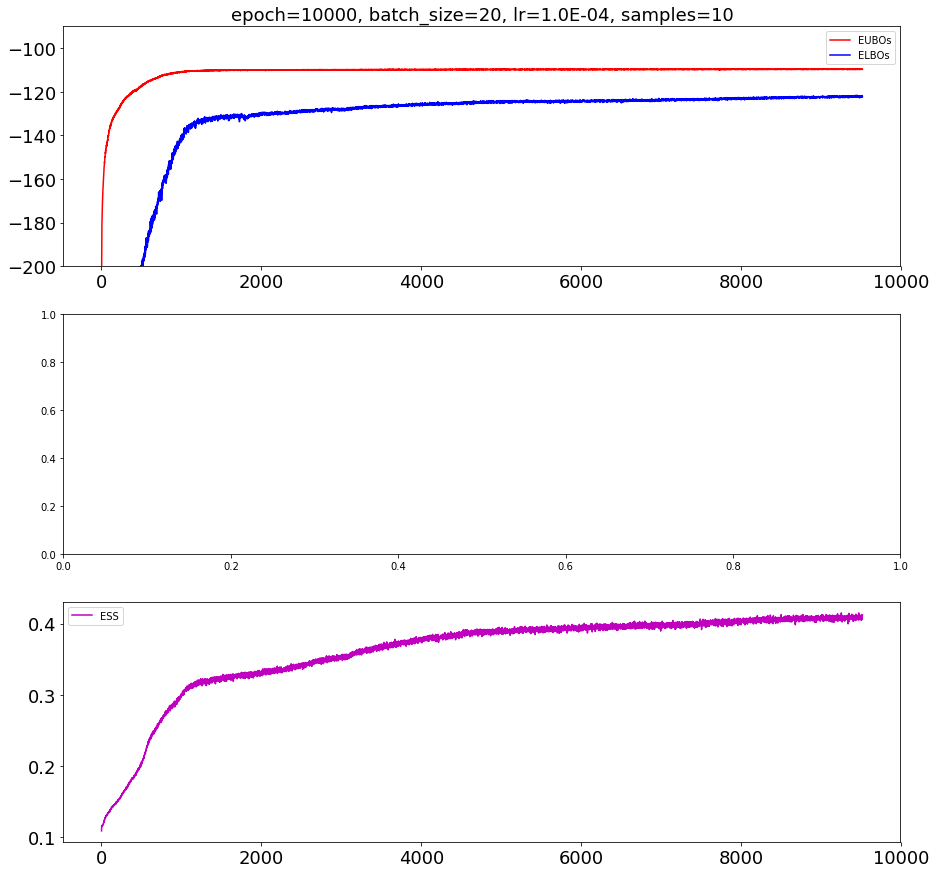

In [10]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [16]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
    if CUDA:
        obs =data.cuda()[:, :, :, :2]
        states = data.cuda()[:, :, :, 2:]
    return obs, states

obs, states = sample_single_batch(NUM_SEQS, N, K, D, batch_size=25)
stat1, stat2, stat3 = data_to_stats(obs, states, N, K, D)
q, p = enc_eta(stat1, stat2, stat3)

In [23]:
def plot_samples(obs, states, q, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_means = q['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q['precisions'].dist.concentration[0] / q['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-12, 12])
        ax.set_xlim([-12, 12])
    plt.savefig('results/modes-' + PATH + '.svg')

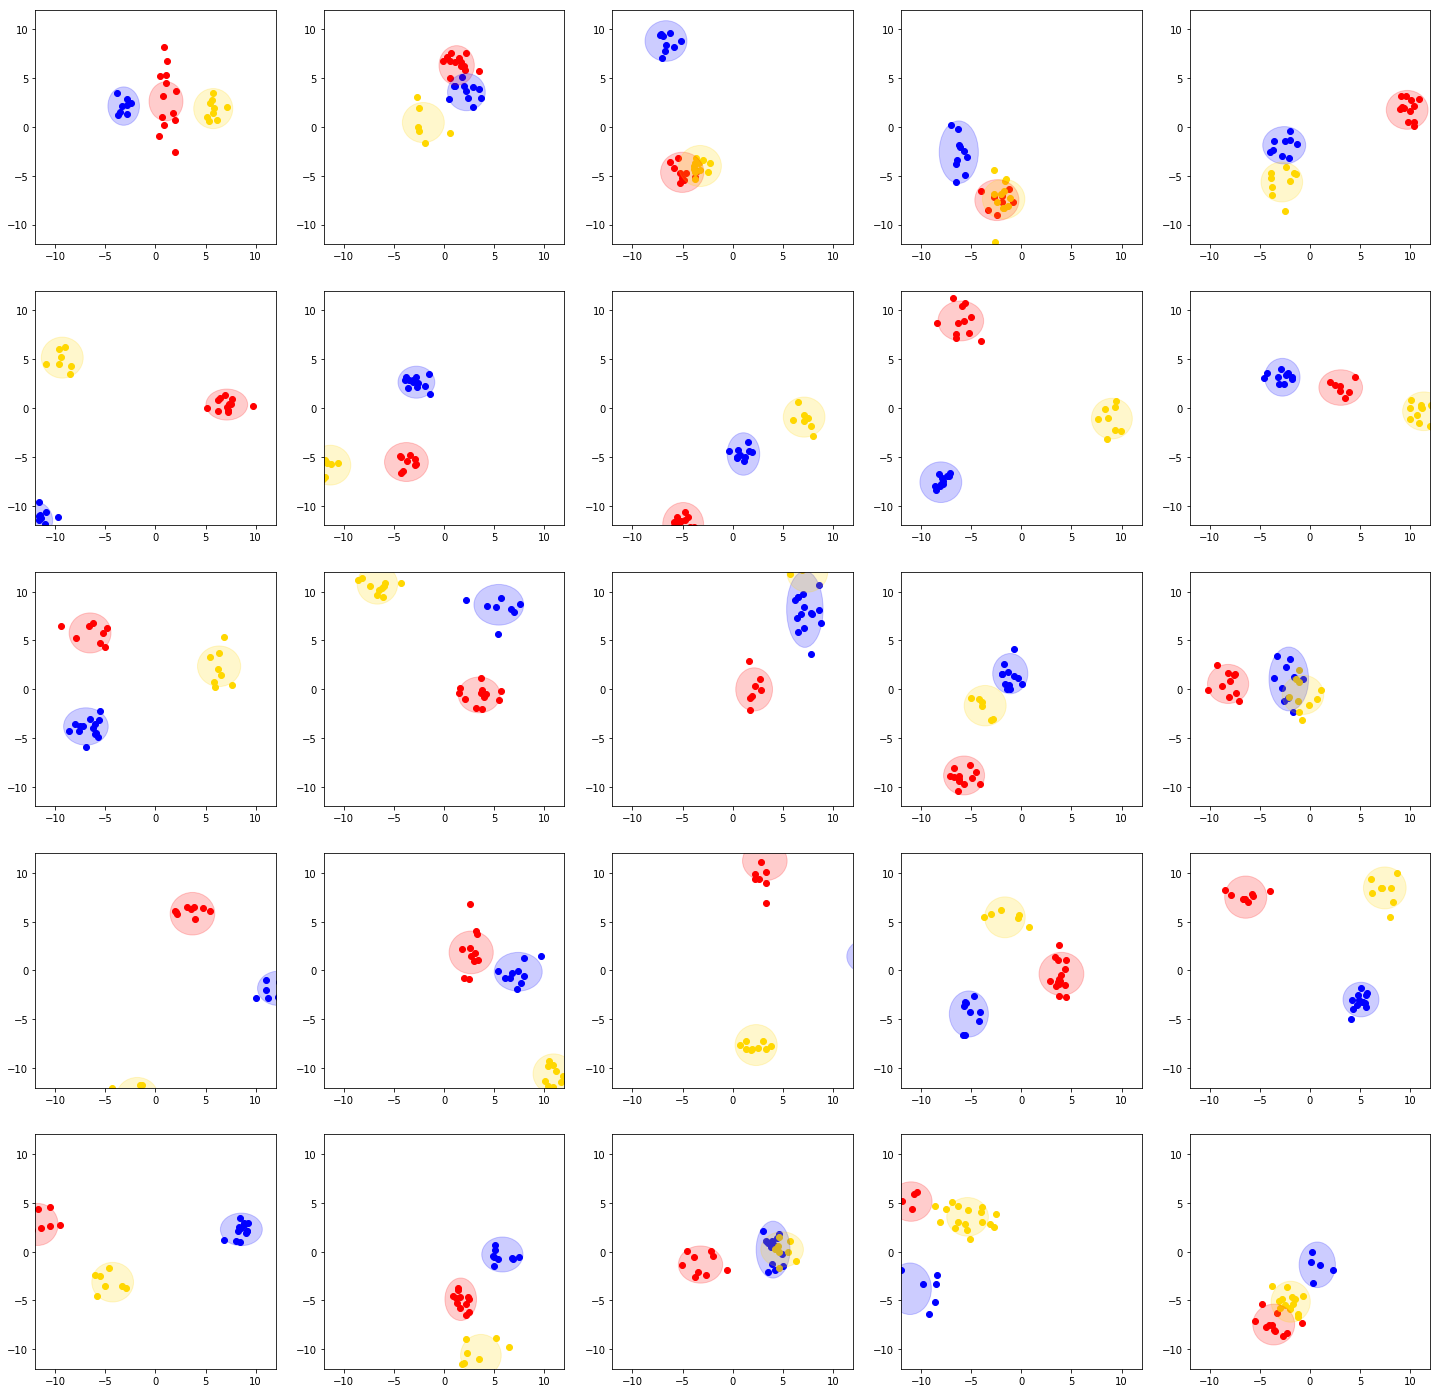

In [24]:
plot_samples(obs, states, q, batch_size=25)

In [ ]:
states[0,0].argmax(-1)